# **Persiapan**

In [2]:
#Libraries
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#QOL
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 10000)
pd.set_option("display.max_colwidth", 5000)

#Preprocessing setup
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#Open stop words
my_file = open("C:/Users/zrmuc/Downloads/combined_stop_words.txt", "r")
content1 = my_file.read()
stopwords = content1.split("\n")

#Open country words
my_file2 = open("C:/Users/zrmuc/Downloads/country2.txt", "r")
content2 = my_file2.read()
countrywords = content2.split("\n")

#Open slang words
my_file3 = open(r"C:\Users\zrmuc\Downloads\combined_slang_words.txt")
content3 = my_file3.read()
slangwords = content3.split('\n')

#Combine stop words
combined_words = stopwords + countrywords + slangwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [3]:
# Fungsi pra-proses
def preprocess(sentence):
    sentence = str(sentence)                                                        #turns sentence to string
    sentence = sentence.lower()                                                     #turns all letters to lowercase
    sentence=sentence.replace('{html}',"")                                          #removes links
    cleanr = re.compile('<.*?>')                                                    #cleaning
    cleantext = re.sub(cleanr, '', sentence)                                        #more cleaning
    rem_url=re.sub(r'http\S+', '',cleantext)                                        #more link removal
    rem_num = re.sub('[0-9]+', '', rem_url)                                         #remove number and special characters
    tokenizer = RegexpTokenizer(r'\w+')                                             #tokenize
    tokens = tokenizer.tokenize(rem_num)                                            #tokenize
    filtered_words = [w for w in tokens if len(w) > 2 if not w in combined_words]   #filtering words
    stem_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(stem_words)


In [4]:
#Definisi fungsi over/undersampling, model, cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

# Define models
tvec = TfidfVectorizer( max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()
nb = MultinomialNB()
rf = RandomForestClassifier()
svm = SVC(kernel = 'linear', random_state = 50)
knn = KNeighborsClassifier()
et = ExtraTreesClassifier(random_state=50)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

#Algorithms: NB, RF, LR, SVM, KNN, ET
def sent_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True,random_state = 500)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        model_fit = pipeline.fit(X[train], Y[train])
        prediction = model_fit.predict(X[test])
        scores = model_fit.score(X[test],Y[test])        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method,zero_division = 0)*100)
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None,zero_division = 0))
        recall.append(recall_score(Y[test], prediction, average=average_method,zero_division = 0)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None,zero_division = 0))
        f1.append(f1_score(Y[test], prediction, average=average_method,zero_division = 0)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None,zero_division = 0))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [4]:
#Definisi fungsi over/undersampling, model, cross-validation
from sklearn.metrics import classification_report, make_scorer, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, TomekLinks, RandomUnderSampler

def multi_unb_sent(text, label):
#Vectorizer
    tv = TfidfVectorizer(max_features=100000)
    unbalanced_tfidf = tv.fit_transform(text)    
    #unbalanced_tfidf = pd.DataFrame(unbalanced_tfidf.todense())
    #unbalanced_tfidf = pd.concat([unbalanced_tfidf, extra])
    rsmpl = [
        RandomOverSampler(random_state = 50),
        SMOTE(random_state = 50),
        NearMiss(),
        TomekLinks(),
        RandomUnderSampler(random_state = 50)
    ] #Over/undersampling models

    metnames = ["ROS", "SMOTE", "Near Miss", "TomekLinks","RUS"] #Over/undersampling names
    names = ["Naive Bayes", "Logistic Regression", "Random Forest", "SVM-linear","SVM-poly","SVM-rbf","SVM-sigmoid", "Extra Trees"] #Model names
    evals = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"] #Evaluation methods
    results = []
    df_results = pd.DataFrame()
    for met in rsmpl:    
        X_resample = []
        y_resample = []
        X_resample, y_resample = met.fit_resample(unbalanced_tfidf, label)
        X_resample = pd.DataFrame(X_resample.todense())
        #Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size = 0.25, random_state = 50)
        %matplotlib inline
        sns.set_style("whitegrid")
        print(met)
        #Model building
        models = [
            MultinomialNB(),
            LogisticRegression(),
            RandomForestClassifier(n_estimators = 500),
            SVC(kernel = 'linear', probability = True),
            SVC(kernel = 'poly', probability = True),
            SVC(kernel = 'rbf', probability = True),
            SVC(kernel = 'sigmoid', probability = True),
            ExtraTreesClassifier(n_estimators=150, random_state=50)
        ]
        skf = StratifiedKFold(n_splits=2)
        for model, name in zip(models, names):
            model_results = []
            print(name)
            for score in evals:
                eval_result = cross_val_score(model, X_resample, y_resample, scoring=score, cv=skf).mean()
                model_results.append(eval_result)
                print(f'{score} - {eval_result}')
            print()
            results.append(model_results)
    print(results)
    return(results)

In [3]:
df_merge['Text'] = df_merge['Text'].replace(r'\n',' ', regex = True) # Remove newline

NameError: name 'df_merge' is not defined

In [8]:
import ftfy
for row in df_merge["Text"]:
    row = ftfy.fix_text(row)

# News

In [9]:
df_merge['cleanText']=df_merge['Text'].map(lambda s:preprocess(s)) 


## **Exploration**

In [10]:
df_merge

Label                                                                        Title                          Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [12]:
#df_merge.to_excel('Sentimentclean.xlsx')

In [11]:
df_merge["Source"].value_counts()

Source
Media Indonesia    45
Mojok              42
Detik              26
Pikiran Rakyat      6
Kompasiana          3
CNBC                2
Name: count, dtype: int64

In [18]:
df_merge['Label'].value_counts()

Label
0     58
1     57
-1     9
Name: count, dtype: int64

In [16]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=[1, 0, -1], ordered=True)
df_merge['Label'] = df_merge['Label'].astype(cat_type)


In [30]:
df_merge = df_merge.replace(r'xd',' ', regex=True)

In [31]:
df_merge = df_merge.replace(r'nya',' ', regex=True)


In [32]:
df_merge = df_merge.replace(r'akibat',' ', regex=True)


In [33]:
df_merge = df_merge.replace(r'hingga',' ', regex=True)


In [34]:
df_merge = df_merge.replace(r'sebab',' ', regex=True)


## Wordcloud

In [29]:
df_positive = df_merge.loc[df_merge['Label'] == 1]
df_neutral = df_merge.loc[df_merge['Label'] == 0]
df_negative = df_merge.loc[df_merge['Label'] == -1]

In [33]:
negative_list=df_negative['cleanText'].tolist()
neutral_list = df_neutral['cleanText'].tolist()
positive_list= df_positive['cleanText'].tolist()

filtered_negative = ("").join(str(negative_list)) #convert the list into a string of spam
filtered_negative = filtered_negative.lower()

filtered_neutral = ("").join(str(neutral_list)) #convert the list into a string of ham
filtered_neutral = filtered_neutral.lower()

filtered_positive = ("").join(str(positive_list)) #convert the list into a string of jam
filtered_positive = filtered_positive.lower()

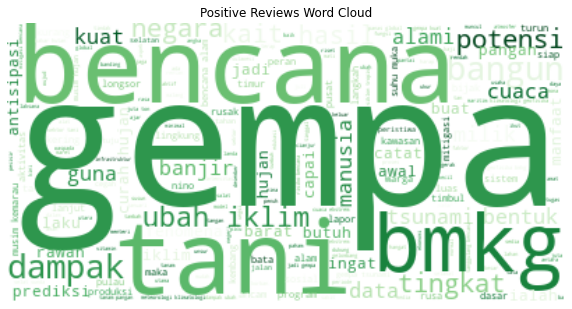

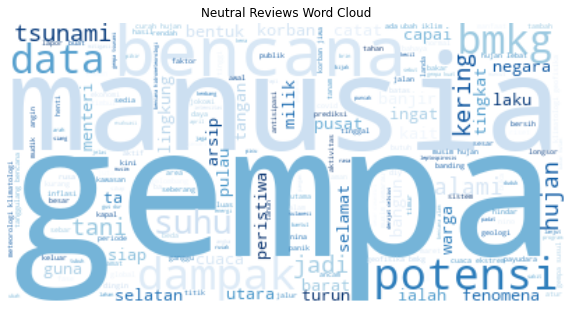

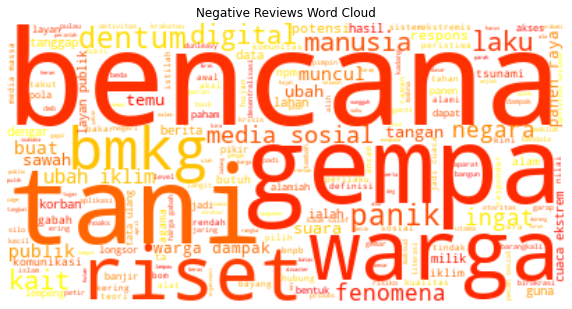

In [34]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Greens").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Blues").generate(filtered_neutral)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Neutral Reviews Word Cloud")
plt.show()

wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="autumn").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

## **Analysis**

In [35]:
from sklearn.pipeline import Pipeline
rf_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', rf)
])

sent_cv(5, df_merge.cleanText, df_merge.Label, rf_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.         0.46153846 0.41666667]
recall:    [0.         0.5        0.45454545]
f1 score:  [0.         0.48       0.43478261]
--------------------------------------------------
              negative    neutral     positive
precision: [0.  0.6 0.6]
recall:    [0.         0.75       0.54545455]
f1 score:  [0.         0.66666667 0.57142857]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.58333333 0.61538462]
recall:    [0.         0.58333333 0.72727273]
f1 score:  [0.         0.58333333 0.66666667]
--------------------------------------------------
              negative    neutral     positive
precision: [0.  0.4 0.4]
recall:    [0.         0.72727273 0.16666667]
f1 score:  [0.         0.51612903 0.23529412]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.6        0.77777778]
recal

In [21]:
from sklearn.pipeline import Pipeline
nb_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', nb)
])

sent_cv(5, df_merge.cleanText, df_merge.Label, nb_pipeline, 'macro')

              negative    neutral     positive
precision: [0.  0.8 0.5]
recall:    [0.         0.33333333 0.90909091]
f1 score:  [0.         0.47058824 0.64516129]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         1.         0.52380952]
recall:    [0.         0.33333333 1.        ]
f1 score:  [0.     0.5    0.6875]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.71428571 0.5       ]
recall:    [0.         0.41666667 0.81818182]
f1 score:  [0.         0.52631579 0.62068966]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.45454545 0.42857143]
recall:    [0.         0.45454545 0.5       ]
f1 score:  [0.         0.45454545 0.46153846]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.83333333 0.611111

In [22]:
from sklearn.pipeline import Pipeline
svm_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', svm)
])

sent_cv(5, df_merge.cleanText, df_merge.Label, svm_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.         0.5        0.53846154]
recall:    [0.         0.5        0.63636364]
f1 score:  [0.         0.5        0.58333333]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.72727273 0.71428571]
recall:    [0.         0.66666667 0.90909091]
f1 score:  [0.         0.69565217 0.8       ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.7        0.53333333]
recall:    [0.         0.58333333 0.72727273]
f1 score:  [0.         0.63636364 0.61538462]
--------------------------------------------------
              negative    neutral     positive
precision: [0.  0.4 0.3]
recall:    [0.         0.54545455 0.25      ]
f1 score:  [0.         0.46153846 0.27272727]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.66666

In [23]:
from sklearn.pipeline import Pipeline
knn_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', knn)
])

sent_cv(5, df_merge.cleanText, df_merge.Label, knn_pipeline, 'macro')

              negative    neutral     positive
precision: [0.  0.5 0.5]
recall:    [0.         0.33333333 0.72727273]
f1 score:  [0.         0.4        0.59259259]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.4        0.42857143]
recall:    [0.         0.33333333 0.54545455]
f1 score:  [0.         0.36363636 0.48      ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.46153846 0.33333333]
recall:    [0.         0.5        0.36363636]
f1 score:  [0.         0.48       0.34782609]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.44444444 0.46666667]
recall:    [0.         0.36363636 0.58333333]
f1 score:  [0.         0.4        0.51851852]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.6    

In [24]:
from sklearn.pipeline import Pipeline
et_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', et)
])

sent_cv(5, df_merge.cleanText, df_merge.Label, et_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.         0.5        0.44444444]
recall:    [0.         0.66666667 0.36363636]
f1 score:  [0.         0.57142857 0.4       ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.  0.6 1. ]
recall:    [0.         1.         0.45454545]
f1 score:  [0.    0.75  0.625]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.5625     0.55555556]
recall:    [0.         0.75       0.45454545]
f1 score:  [0.         0.64285714 0.5       ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.44444444 0.42857143]
recall:    [0.         0.72727273 0.25      ]
f1 score:  [0.         0.55172414 0.31578947]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.66666667 0.88888889]

## **Class Imbalance**

In [19]:
news_unb_result = multi_unb_sent(df_merge.cleanText,df_merge.Label)

RandomOverSampler(random_state=50)
Naive Bayes
accuracy - 0.6666666666666667
precision_weighted - 0.706674740603312
recall_weighted - 0.6666666666666667
f1_weighted - 0.6422982259551482
roc_auc_ovr_weighted - 0.848692033293698

Logistic Regression
accuracy - 0.6896551724137931
precision_weighted - 0.7330246913580246
recall_weighted - 0.6896551724137931
f1_weighted - 0.6765500768829338
roc_auc_ovr_weighted - 0.8470075307174001

Random Forest
accuracy - 0.6954022988505747
precision_weighted - 0.7919337606837606
recall_weighted - 0.7068965517241379
f1_weighted - 0.6764588142156664
roc_auc_ovr_weighted - 0.8983353151010702

SVM-linear
accuracy - 0.6896551724137931
precision_weighted - 0.7374835309617918
recall_weighted - 0.6896551724137931
f1_weighted - 0.6789900254973784
roc_auc_ovr_weighted - 0.7954815695600476

SVM-poly
accuracy - 0.7011494252873562
precision_weighted - 0.7262936319139924
recall_weighted - 0.7011494252873562
f1_weighted - 0.7035286935286935
roc_auc_ovr_weighted - 0.7353

C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.11004709576138147
recall_weighted - 0.2582417582417582
f1_weighted - 0.148962148962149
roc_auc_ovr_weighted - 0.5717948717948719

Logistic Regression
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.16117216117216118
recall_weighted - 0.3351648351648352
f1_weighted - 0.21268143621084795
roc_auc_ovr_weighted - 0.5918956043956045

Random Forest
accuracy - 0.4862637362637363


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5097680097680097
recall_weighted - 0.4862637362637363
f1_weighted - 0.4137221752606368
roc_auc_ovr_weighted - 0.7347069597069598

SVM-linear
accuracy - 0.29945054945054944


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.15293040293040294
recall_weighted - 0.29945054945054944
f1_weighted - 0.19902597402597402
roc_auc_ovr_weighted - 0.47609890109890113

SVM-poly
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.15803244374672945
recall_weighted - 0.3351648351648352
f1_weighted - 0.20894660894660894
roc_auc_ovr_weighted - 0.3891483516483517

SVM-rbf
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.15803244374672945
recall_weighted - 0.3351648351648352
f1_weighted - 0.20894660894660894
roc_auc_ovr_weighted - 0.4225274725274726

SVM-sigmoid
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.15803244374672945
recall_weighted - 0.3351648351648352
f1_weighted - 0.20894660894660894
roc_auc_ovr_weighted - 0.44488705738705736

Extra Trees
accuracy - 0.44505494505494503


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.39331501831501825
recall_weighted - 0.44505494505494503
f1_weighted - 0.3868131868131869
roc_auc_ovr_weighted - 0.6801739926739927

TomekLinks()
Naive Bayes
accuracy - 0.6
precision_weighted - 0.6049424119241192


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_weighted - 0.6
f1_weighted - 0.5544258130081301
roc_auc_ovr_weighted - 0.7533559926386013

Logistic Regression
accuracy - 0.62


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6098333333333333
recall_weighted - 0.62
f1_weighted - 0.569512607098814
roc_auc_ovr_weighted - 0.7342887048539222

Random Forest
accuracy - 0.6


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6110336817653891
recall_weighted - 0.6
f1_weighted - 0.5305516725853048
roc_auc_ovr_weighted - 0.7649620427881296

SVM-linear
accuracy - 0.61


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6284481364702078
recall_weighted - 0.61
f1_weighted - 0.563592729326797
roc_auc_ovr_weighted - 0.477339084426041

SVM-poly
accuracy - 0.61


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5641208791208792
recall_weighted - 0.61
f1_weighted - 0.5749516797855546
roc_auc_ovr_weighted - 0.26740763745111573

SVM-rbf
accuracy - 0.61


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5977631578947369
recall_weighted - 0.61
f1_weighted - 0.5590185976029756
roc_auc_ovr_weighted - 0.276570278352887

SVM-sigmoid
accuracy - 0.6


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5852771836007131
recall_weighted - 0.6
f1_weighted - 0.5523240648240648
roc_auc_ovr_weighted - 0.5071369910282953

Extra Trees
accuracy - 0.5800000000000001


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5844848955842499
recall_weighted - 0.5800000000000001
f1_weighted - 0.534885262940229
roc_auc_ovr_weighted - 0.7500530825856913

RandomUnderSampler(random_state=50)
Naive Bayes
accuracy - 0.3708791208791209
precision_weighted - 0.4725274725274725


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_weighted - 0.3708791208791209
f1_weighted - 0.3135638870932989
roc_auc_ovr_weighted - 0.6815934065934066

Logistic Regression
accuracy - 0.44780219780219777


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.5532967032967033
recall_weighted - 0.44780219780219777
f1_weighted - 0.39732457085398265
roc_auc_ovr_weighted - 0.6740537240537241

Random Forest
accuracy - 0.5164835164835164
precision_weighted - 0.7136970172684459
recall_weighted - 0.48351648351648346
f1_weighted - 0.43992900414603714
roc_auc_ovr_weighted - 0.7732448107448107

SVM-linear
accuracy - 0.41208791208791207


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.3228676085818943
recall_weighted - 0.41208791208791207
f1_weighted - 0.3288766788766789
roc_auc_ovr_weighted - 0.3537393162393163

SVM-poly
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.16902145473574043
recall_weighted - 0.3351648351648352
f1_weighted - 0.21142105757490376
roc_auc_ovr_weighted - 0.3811965811965812

SVM-rbf
accuracy - 0.3351648351648352


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.16004709576138149
recall_weighted - 0.3351648351648352
f1_weighted - 0.20879120879120877
roc_auc_ovr_weighted - 0.3374542124542125

SVM-sigmoid
accuracy - 0.41208791208791207
precision_weighted - 0.3869701726844584


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_weighted - 0.41208791208791207
f1_weighted - 0.3122100122100122
roc_auc_ovr_weighted - 0.3672466422466423

Extra Trees
accuracy - 0.6318681318681318
precision_weighted - 0.731990231990232
recall_weighted - 0.6318681318681318
f1_weighted - 0.6025343703915133
roc_auc_ovr_weighted - 0.7625

[[0.6666666666666667, 0.706674740603312, 0.6666666666666667, 0.6422982259551482, 0.848692033293698], [0.6896551724137931, 0.7330246913580246, 0.6896551724137931, 0.6765500768829338, 0.8470075307174001], [0.6954022988505747, 0.7919337606837606, 0.7068965517241379, 0.6764588142156664, 0.8983353151010702], [0.6896551724137931, 0.7374835309617918, 0.6896551724137931, 0.6789900254973784, 0.7954815695600476], [0.7011494252873562, 0.7262936319139924, 0.7011494252873562, 0.7035286935286935, 0.7353349187475228], [0.6896551724137931, 0.731517094017094, 0.6896551724137931, 0.6782413670351166, 0.7935988902100675], [0.6724137931034482, 0.7243265993265993, 0.6724137931034482, 0.6670568414983254, 0.79647245342

In [51]:
df_model = pd.DataFrame(news_unb_result).transpose()
new_row = pd.DataFrame({("Naive Bayes", "Logistic Regression", "Random Forest", "SVM-linear","SVM-poly","SVM-rbf","SVM-sigmoid", "Extra Trees")*5}, index=[0])
metnames = ["ROS", "SMOTE", "Near Miss", "TomekLinks","RUS"]
evals = [0,"accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "AUC_ROC_weighted"]

df2 = pd.concat([new_row,df_model.loc[:]]).reset_index(drop=True)
df2.index = evals
df2.columns = np.repeat(metnames,8)
df3 = df2.transpose()
print(df3)

                              0  accuracy precision_weighted recall_weighted f1_weighted AUC_ROC_weighted
ROS                 Naive Bayes  0.666667           0.707391        0.666667     0.64283         0.848296
ROS         Logistic Regression  0.678161           0.722692        0.678161    0.666124         0.847998
ROS               Random Forest  0.724138           0.782937        0.712644    0.675146         0.903191
ROS                  SVM-linear  0.678161           0.717829        0.678161    0.668031         0.795184
ROS                    SVM-poly  0.701149           0.724116        0.701149    0.704256         0.736326
ROS                     SVM-rbf  0.695402           0.737362        0.695402    0.685915         0.795283
ROS                 SVM-sigmoid  0.666667           0.719618        0.666667    0.663423         0.797067
ROS                 Extra Trees  0.695402           0.741373        0.695402    0.671785         0.900515
SMOTE               Naive Bayes  0.672414     

In [52]:
df3.to_csv('BMKG_news_review_performance.csv')

In [53]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
le = LabelEncoder()
y = le.fit_transform(df_merge['Label'])

# Tokenize the text

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_merge['Text'])
X_seq = tokenizer.texts_to_sequences(df_merge['Text'])

# Pad sequences
X_pad = pad_sequences(X_seq, padding='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=50)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim = 10000, output_dim = 10000))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)
print(predictions)

Epoch 1/10


c:\Users\zrmuc\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 210s 21s/step - loss: 0.0000e+00 - accuracy: 0.4040 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 2/10
10/10 [==============================] - 250s 26s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 3/10
10/10 [==============================] - 281s 28s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 4/10
10/10 [==============================] - 287s 29s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 5/10
10/10 [==============================] - 293s 29s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 6/10
10/10 [==============================] - 299s 30s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 7/10
10/10 [==============================] - 318s 32s/step - loss: 0.0000e+00 - accuracy: 0.4747 - val_l

# Info BMKG reviews

In [22]:
df_app_review = pd.read_csv(r"C:\Users\zrmuc\Downloads\new label aplikasi.csv", nrows = 3000)
df_app_review['score']= df_app_review['score'].astype('category')

In [23]:
print(df_app_review.label.value_counts())

label
 1.0    1966
-1.0     786
 0.0     247
Name: count, dtype: int64


In [24]:
df_app_review['content'] = df_app_review['content'].replace(r'\n',' ', regex=True) 

In [25]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [26]:
import ftfy
for row in df_app_review["content"]:
    row = remove_emojis(row)
    row = ftfy.fix_text(row)

In [27]:
df_app_review['cleancontent'] = df_app_review['content'].map(lambda s:preprocess(s))

In [20]:
print(df_app_review.cleancontent.to_string())

0                                                                                                                                                                                                                                  gempa baru
1                                                                                                                                                                                                                                      akurat
3                                                                                                                                                                                       sumpah aplikasi cuaca loading nya muyak kadang kadang
4                                                                                                                                                                                         info cepat angin hujan takut angin kencang khawatir
5                                               

In [28]:
df_app_review = df_app_review[df_app_review['cleancontent'] != ''] 

In [29]:
df_app_review.to_csv("infobmkg2.csv")

## Wordcloud

In [34]:
df_app_review = df_app_review.replace(r'nya','',regex = True)

In [40]:
df_app_review = df_app_review.replace(r'aplikasi','',regex = True)

In [41]:
df_positive = df_app_review.loc[df_app_review['label'] == 1]
df_neutral = df_app_review.loc[df_app_review['label'] == 0]
df_negative = df_app_review.loc[df_app_review['label'] == -1]

In [42]:
negative_list= df_negative['cleancontent'].tolist()
neutral_list = df_neutral['cleancontent'].tolist()
positive_list= df_positive['cleancontent'].tolist()

filtered_negative = ("").join(str(negative_list)) #convert the list into a string of spam
filtered_negative = filtered_negative.lower()

filtered_neutral = ("").join(str(neutral_list)) #convert the list into a string of ham
filtered_neutral = filtered_neutral.lower()

filtered_positive = ("").join(str(positive_list)) #convert the list into a string of jam
filtered_positive = filtered_positive.lower()

## Analysis

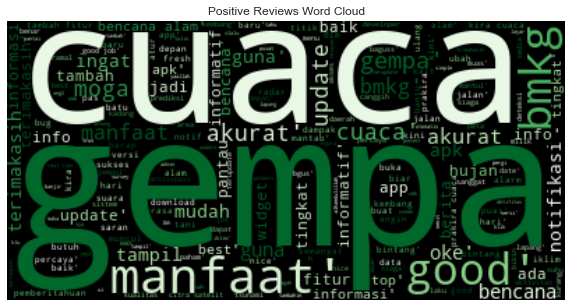

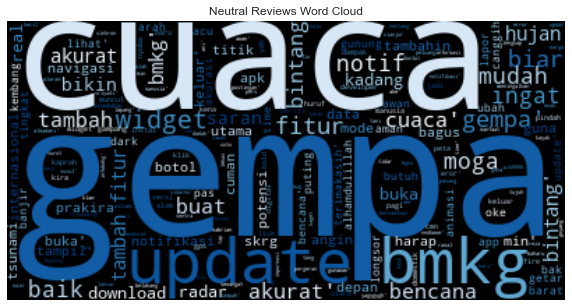

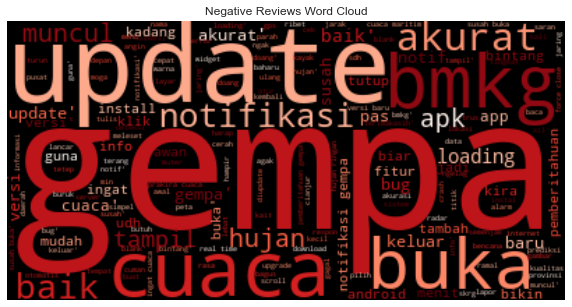

In [46]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "black", colormap="Greens").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "black", colormap="Blues").generate(filtered_neutral)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Neutral Reviews Word Cloud")
plt.show()

wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "black", colormap="Reds").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

### Unbalanced

In [19]:
from sklearn.pipeline import Pipeline
rf_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', rf)
])

sent_cv(5, df_app_review.cleancontent, df_app_review.label, rf_pipeline, 'weighted')

KeyError: '[2, 8, 13, 20, 21, 25, 33, 34, 40, 42, 47, 57, 58, 87, 88, 102, 106, 114, 117, 121, 125, 134, 138, 144, 145, 147, 159, 161, 165, 177, 179, 189, 192, 195, 197, 200, 202, 208, 210, 213, 215, 218, 222, 223, 231, 233, 247, 249, 253, 258, 263, 270, 273, 274, 275, 278, 290, 294, 296, 304, 311, 312, 313, 314, 317, 320, 337, 340, 346, 366, 373, 376, 381, 388, 389, 391, 394, 398, 401, 404, 405, 407, 410, 415, 423, 425, 434, 436, 451, 453, 455, 460, 462, 464, 470, 471, 479, 481, 484, 485, 487, 489, 495, 496, 501, 505, 507, 512, 516, 517, 518, 520, 521, 523, 537, 544, 553, 557, 558, 562, 566, 570, 573, 578, 579, 587, 614, 619, 627, 631, 634, 635, 637, 640, 641, 647, 654, 657, 663, 664, 665, 666, 669, 671, 676, 678, 679, 683, 691, 698, 703, 710, 711, 714, 717, 720, 723, 726, 728, 735] not in index'

In [154]:
from sklearn.pipeline import Pipeline
nb_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', nb)
])

sent_cv(5, df_app_review.cleancontent, df_app_review.label, nb_pipeline, 'weighted')

              negative    neutral     positive
precision: [1.         0.         0.66666667]
recall:    [0.10869565 0.         1.        ]
f1 score:  [0.19607843 0.         0.8       ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.5        0.         0.66326531]
recall:    [0.04347826 0.         1.        ]
f1 score:  [0.08       0.         0.79754601]
--------------------------------------------------
              negative    neutral     positive
precision: [1.         0.         0.66494845]
recall:    [0.12765957 0.         1.        ]
f1 score:  [0.22641509 0.         0.79876161]
--------------------------------------------------
              negative    neutral     positive
precision: [0.75       0.         0.65306122]
recall:    [0.06521739 0.         0.99224806]
f1 score:  [0.12       0.         0.78769231]
--------------------------------------------------
              negative    neutral     positive
precision

In [155]:
from sklearn.pipeline import Pipeline
svm_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', svm)
])

sent_cv(5, df_app_review.cleancontent, df_app_review.label, svm_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.53658537 0.33333333 0.73076923]
recall:    [0.47826087 0.04166667 0.87692308]
f1 score:  [0.50574713 0.07407407 0.7972028 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.57142857 0.5        0.73529412]
recall:    [0.34782609 0.04166667 0.96153846]
f1 score:  [0.43243243 0.07692308 0.83333333]
--------------------------------------------------
              negative    neutral     positive
precision: [0.73529412 0.         0.75151515]
recall:    [0.53191489 0.         0.96124031]
f1 score:  [0.61728395 0.         0.84353741]
--------------------------------------------------
              negative    neutral     positive
precision: [0.65714286 0.         0.74390244]
recall:    [0.5        0.         0.94573643]
f1 score:  [0.56790123 0.         0.83276451]
--------------------------------------------------
              negative    neutral     positive
precision

In [156]:
from sklearn.pipeline import Pipeline
knn_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', knn)
])

sent_cv(5, df_app_review.cleancontent, df_app_review.label, knn_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.         0.         0.64824121]
recall:    [0.         0.         0.99230769]
f1 score:  [0.         0.         0.78419453]
--------------------------------------------------
              negative    neutral     positive
precision: [0.         0.         0.64824121]
recall:    [0.         0.         0.99230769]
f1 score:  [0.         0.         0.78419453]
--------------------------------------------------
              negative    neutral     positive
precision: [0.    0.    0.645]
recall:    [0. 0. 1.]
f1 score:  [0.         0.         0.78419453]
--------------------------------------------------
              negative    neutral     positive
precision: [1.         0.         0.65151515]
recall:    [0.04347826 0.         1.        ]
f1 score:  [0.08333333 0.         0.78899083]
--------------------------------------------------
              negative    neutral     positive
precision: [1.         0.         0.64824121]
re

In [157]:
from sklearn.pipeline import Pipeline
et_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', et)
])

sent_cv(5, df_app_review.cleancontent, df_app_review.label, et_pipeline, 'weighted')

              negative    neutral     positive
precision: [0.58064516 0.28571429 0.72222222]
recall:    [0.39130435 0.08333333 0.9       ]
f1 score:  [0.46753247 0.12903226 0.80136986]
--------------------------------------------------
              negative    neutral     positive
precision: [0.4516129  0.         0.73493976]
recall:    [0.30434783 0.         0.93846154]
f1 score:  [0.36363636 0.         0.82432432]
--------------------------------------------------
              negative    neutral     positive
precision: [0.8        0.         0.74705882]
recall:    [0.5106383  0.         0.98449612]
f1 score:  [0.62337662 0.         0.84949833]
--------------------------------------------------
              negative    neutral     positive
precision: [0.7        0.         0.70224719]
recall:    [0.30434783 0.         0.96899225]
f1 score:  [0.42424242 0.         0.81433225]
--------------------------------------------------
              negative    neutral     positive
precision

## **Class Imbalance**

In [47]:
bresult = multi_unb_sent(df_app_review.cleancontent, df_app_review.label)

RandomOverSampler(random_state=50)
Naive Bayes
accuracy - 0.7803145611364789
precision_weighted - 0.7866149120470545
recall_weighted - 0.7803145611364789
f1_weighted - 0.7802243403986135
roc_auc_ovr_weighted - 0.9194606034069348

Logistic Regression
accuracy - 0.8077118214104515
precision_weighted - 0.8084471183119359
recall_weighted - 0.8077118214104515
f1_weighted - 0.8073129263419179
roc_auc_ovr_weighted - 0.9213629978678665

Random Forest
accuracy - 0.8721461187214612
precision_weighted - 0.8704739968228583
recall_weighted - 0.8723997970573313
f1_weighted - 0.8697535025190058
roc_auc_ovr_weighted - 0.9671863018332023

SVM-linear
accuracy - 0.8115169964485033
precision_weighted - 0.8113269150619162
recall_weighted - 0.8115169964485033
f1_weighted - 0.8112937394470875
roc_auc_ovr_weighted - 0.9206641275666108

SVM-poly
accuracy - 0.8361237950279046
precision_weighted - 0.8499811168117758
recall_weighted - 0.8361237950279046
f1_weighted - 0.8346417481093796
roc_auc_ovr_weighted - 0.94

C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_weighted - 0.7299093879976233
f1_weighted - 0.6856021675767201
roc_auc_ovr_weighted - 0.8379646840847751

Logistic Regression
accuracy - 0.7239321692864473


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6713599476497685
recall_weighted - 0.7239321692864473
f1_weighted - 0.682299088347325
roc_auc_ovr_weighted - 0.8368722587907222

Random Forest
accuracy - 0.728524803516448
precision_weighted - 0.6928717499195762
recall_weighted - 0.7266882562253552
f1_weighted - 0.6911887010821558
roc_auc_ovr_weighted - 0.8291758017558947

SVM-linear
accuracy - 0.7354126998595581
precision_weighted - 0.6810580581148148
recall_weighted - 0.7354126998595581
f1_weighted - 0.6992496086031246
roc_auc_ovr_weighted - 0.8291644098033641

SVM-poly
accuracy - 0.6545695929887106


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6240637114676133
recall_weighted - 0.6545695929887106
f1_weighted - 0.5844851946600507
roc_auc_ovr_weighted - 0.8174134955405976

SVM-rbf
accuracy - 0.7262265873980447


C:\Users\zrmuc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_weighted - 0.6729186762508015
recall_weighted - 0.7262265873980447
f1_weighted - 0.6856208093154221
roc_auc_ovr_weighted - 0.8351339731067104

SVM-sigmoid
accuracy - 0.7248487549289688
precision_weighted - 0.6679313630044144
recall_weighted - 0.7248487549289688
f1_weighted - 0.6861241255451079
roc_auc_ovr_weighted - 0.8102973778337764

Extra Trees
accuracy - 0.7349590490466159
precision_weighted - 0.7031800751880507
recall_weighted - 0.7349590490466159
f1_weighted - 0.7068344962132372
roc_auc_ovr_weighted - 0.8261243192677517

RandomUnderSampler(random_state=50)
Naive Bayes
accuracy - 0.5113636363636364
precision_weighted - 0.503820670987074
recall_weighted - 0.5113636363636364
f1_weighted - 0.49413050140130094
roc_auc_ovr_weighted - 0.6993801652892562

Logistic Regression
accuracy - 0.543560606060606
precision_weighted - 0.5660315010830688
recall_weighted - 0.543560606060606
f1_weighted - 0.5453798460303811
roc_auc_ovr_weighted - 0.7052664428374655

Random Forest
accuracy - 

In [48]:
df_model = pd.DataFrame(bresult).transpose()
new_row = pd.DataFrame({("Naive Bayes", "Logistic Regression", "Random Forest", "SVM-linear","SVM-poly","SVM-rbf","SVM-sigmoid", "Extra Trees")*5}, index=[0])
metnames = ["ROS", "SMOTE", "Near Miss", "TomekLinks","RUS"]
evals = [0,"accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "AUC_ROC_weighted"]

df2 = pd.concat([new_row,df_model.loc[:]]).reset_index(drop=True)
df2.index = evals
df2.columns = np.repeat(metnames,8)
df3 = df2.transpose()
print(df3)

                              0  accuracy precision_weighted recall_weighted f1_weighted AUC_ROC_weighted
ROS                 Naive Bayes  0.780315           0.786615        0.780315    0.780224         0.919461
ROS         Logistic Regression  0.807712           0.808447        0.807712    0.807313         0.921363
ROS               Random Forest  0.872146           0.870474          0.8724    0.869754         0.967186
ROS                  SVM-linear  0.811517           0.811327        0.811517    0.811294         0.920664
ROS                    SVM-poly  0.836124           0.849981        0.836124    0.834642         0.948468
ROS                     SVM-rbf  0.860223           0.861703        0.860223     0.86063         0.942123
ROS                 SVM-sigmoid  0.758752           0.760386        0.758752    0.759032         0.869598
ROS                 Extra Trees   0.87519           0.875136         0.87519    0.875033         0.971686
SMOTE               Naive Bayes   0.74759     

In [49]:
df3.to_csv('BMKG_app_review_performance.csv')

## NN

In [126]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
le = LabelEncoder()
y = le.fit_transform(df_app_review.label)

# Tokenize the text

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_app_review.cleancontent)
X_seq = tokenizer.texts_to_sequences(df_app_review.cleancontent)

# Pad sequences
X_pad = pad_sequences(X_seq, padding='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=50)

# Build the LSTM model
model = Sequential()
model.add(Embedding(10000, 10000,input_length = X_pad.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

# Compile the model
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)
#print(predictions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 10000)         100000000 
                                                                 
 spatial_dropout1d (SpatialD  (None, 37, 10000)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 500)               21002000  
                                                                 
 dense (Dense)               (None, 1)                 501       
                                                                 
Total params: 121,002,501
Trainable params: 121,002,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


c:\Users\zrmuc\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 127s 6s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 2/10
19/19 [==============================] - 128s 7s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 3/10
19/19 [==============================] - 119s 6s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 4/10
19/19 [==============================] - 127s 7s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 5/10
19/19 [==============================] - 99s 5s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 6/10
19/19 [==============================] - 97s 5s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.0000e+00 - val_accuracy: 0.1678
Epoch 7/10
19/19 [==============================] - 96s 5s/step - loss: 0.0000e+00 - accuracy: 0.1261 - val_loss: 0.000